In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from urllib.request import urlopen

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


#  Data from NDBC **url**

In [4]:
STATION = "44014"

def load_ndbc_stdmet(station, year):
    url = (
        f"https://www.ndbc.noaa.gov/view_text_file.php?"
        f"filename={station}h{year}.txt.gz&dir=data/historical/stdmet/"
    )
    print("Fetching:", url)

    df = pd.read_csv(
        url,
        sep=r"\s+",
        header=None,
        engine="python",
        dtype=str  # keep as string, we’ll parse ourselves
    )
    return df
expected_date_time_cols = ["YYYY", "MM", "DD", "hh", "mm"]

all_cols_full = [
    "YYYY", "MM", "DD", "hh", "mm",   # date/time
    "WDIR", "WSPD", "GST", "WVHT", "DPD", "APD", "MWD",
    "PRES", "ATMP", "WTMP", "DEWP", "VIS", "TIDE"
]

def prep_raw(df_raw):

    df = df_raw.copy()
    current_cols = df.columns.tolist()
    # rename first 5 cols
    rename_map = dict(zip(current_cols[:len(expected_date_time_cols)], expected_date_time_cols))
    df = df.rename(columns=rename_map)

    # drop header rows like '#yr'
    df = df[~df["YYYY"].astype(str).str.contains("#", na=False)]


    cur = df.columns.tolist()
    rename_map2 = dict(zip(cur, all_cols_full[:len(cur)]))
    df = df.rename(columns=rename_map2)

    df = df.reset_index(drop=True)
    return df


def add_datetime_index(df):
    """
    Create a proper datetime index from YYYY MM DD hh mm.
    """
    df = df.copy()
    # convert date/time to int
    for c in ["YYYY", "MM", "DD", "hh", "mm"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    dt = pd.to_datetime(
        dict(
            year=df["YYYY"].astype(int),
            month=df["MM"].astype(int),
            day=df["DD"].astype(int),
            hour=df["hh"].astype(int),
            minute=df["mm"].astype(int),
        ),
        errors="coerce"
    )

    df.index = dt
    df = df.drop(columns=["YYYY", "MM", "DD", "hh", "mm"])
    df = df.sort_index()
    df = df[~df.index.isna()]  # drop bad datetime rows
    return df



Data:

In [5]:
# Load & prep 2021–2024
dfs = []
for year in [2021, 2022, 2023, 2024]:
    raw = load_ndbc_stdmet(STATION, year)
    raw = prep_raw(raw)
    df_y = add_datetime_index(raw)
    dfs.append(df_y)

df_all = pd.concat(dfs).sort_index()
print("Raw combined shape:", df_all.shape)

# Split by year
df_train = df_all[df_all.index.year.isin([2021, 2022, 2023])]
df_test  = df_all[df_all.index.year == 2024]



Fetching: https://www.ndbc.noaa.gov/view_text_file.php?filename=44014h2021.txt.gz&dir=data/historical/stdmet/
Fetching: https://www.ndbc.noaa.gov/view_text_file.php?filename=44014h2022.txt.gz&dir=data/historical/stdmet/
Fetching: https://www.ndbc.noaa.gov/view_text_file.php?filename=44014h2023.txt.gz&dir=data/historical/stdmet/
Fetching: https://www.ndbc.noaa.gov/view_text_file.php?filename=44014h2024.txt.gz&dir=data/historical/stdmet/
Raw combined shape: (173666, 13)


# feature engineering

In [6]:
import numpy as np
import pandas as pd

def feature_engineering(df):
    df = df.copy()

    # Columns we CARE about
    numeric_cols = [
        "WDIR", "WSPD", "GST", "PRES", "ATMP", "WTMP", "WVHT"
    ]

    # Convert to numeric
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Drop missing target
    df = df.dropna(subset=["WVHT"])

    #  Wind direction (circular)
    if "WDIR" in df.columns:
        rad = np.deg2rad(df["WDIR"])
        df["WDIR_sin"] = np.sin(rad)
        df["WDIR_cos"] = np.cos(rad)

    # Time features (cyclical)
    df["hour"] = df.index.hour
    df["dayofyear"] = df.index.dayofyear

    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

    df["day_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 365)
    df["day_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 365)

    return df


df_fe = feature_engineering(df_all)
df_fe["WVHT"] = pd.to_numeric(df_fe["WVHT"], errors="coerce")
df_fe = df_fe[df_fe["WVHT"] < 20]   # keep only physically valid waves (meters)


# Split by year
df_train = df_fe[df_fe.index.year.isin([2021, 2022, 2023])]
df_test  = df_fe[df_fe.index.year == 2024]

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)



Train shape: (24126, 21)
Test shape: (17405, 21)


# Selected Features

In [7]:
feature_cols = [
    "WSPD", "GST", "PRES", "ATMP", "WTMP",
    "WDIR_sin", "WDIR_cos",
    "hour_sin", "hour_cos",
    "day_sin", "day_cos"
]

feature_cols = [c for c in feature_cols if c in df_fe.columns]

X_train = df_train[feature_cols].dropna()
y_train = df_train.loc[X_train.index, "WVHT"]

X_test  = df_test[feature_cols].dropna()
y_test  = df_test.loc[X_test.index, "WVHT"]

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)


X_train: (24126, 11)
X_test: (17405, 11)


#SVR Model

In [12]:



N = 24126
X_train_svr = X_train.iloc[-N:]
y_train_svr = y_train.iloc[-N:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svr)
X_test_scaled  = scaler.transform(X_test)

svr = SVR(
    kernel="rbf",
    C=10.0,
    epsilon=0.1,
    gamma="scale"
)

svr.fit(X_train_scaled, y_train_svr)
y_pred_svr = svr.predict(X_test_scaled)

rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
mae_svr = np.sqrt(mean_absolute_error(y_test, y_pred_svr))
r2_svr   = r2_score(y_test, y_pred_svr)

print("SVR RMSE:", rmse_svr)
print("SVR MAE  :",mae_svr )
print("SVR R2  :", r2_svr)


SVR RMSE: 0.5429933204000014
SVR MAE  : 0.6293368797439303
SVR R2  : 0.46589909998163803


In [14]:
print("Features used in SVR model:")
print(list(X_train_svr.columns))
print("\nX shape:", X_train_svr.shape)
print("y shape:", y_train_svr.shape)
print("\nTarget stats (WVHT):")
print(y_train.describe())
print("SVR performance on test set:")
print('RSME_SVR: ',rmse_svr)
print('MAE_SVR: ',mae_svr)
print('R^2_SVR: ',r2_svr)
y_test.describe()







Features used in SVR model:
['WSPD', 'GST', 'PRES', 'ATMP', 'WTMP', 'WDIR_sin', 'WDIR_cos', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']

X shape: (24126, 11)
y shape: (24126,)

Target stats (WVHT):
count    24126.000000
mean         1.384791
std          0.776490
min          0.290000
25%          0.850000
50%          1.170000
75%          1.690000
max          8.470000
Name: WVHT, dtype: float64
SVR performance on test set:
RSME_SVR:  0.5429933204000014
MAE_SVR:  0.6293368797439303
R^2_SVR:  0.46589909998163803


,WVHT
count,17405.000000
mean,1.459317
std,0.743011
min,0.290000
25%,0.930000
50%,1.270000
75%,1.820000
max,7.140000


# SVM MODEL PLOT

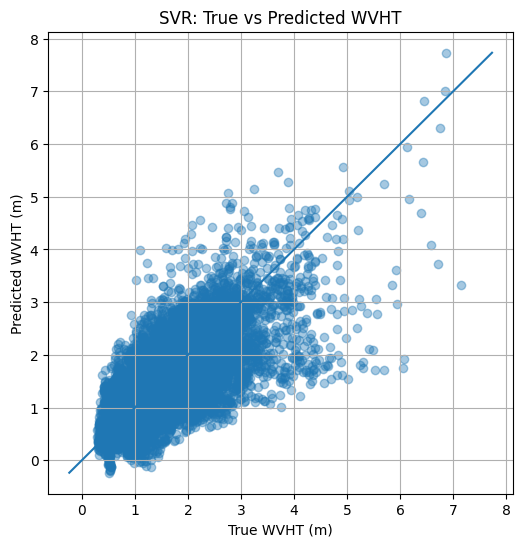

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_svr, alpha=0.4)
min_val = min(y_test.min(), y_pred_svr.min())
max_val = max(y_test.max(), y_pred_svr.max())
plt.plot([min_val, max_val], [min_val, max_val])
plt.xlabel("True WVHT (m)")
plt.ylabel("Predicted WVHT (m)")
plt.title("SVR: True vs Predicted WVHT")
plt.grid(True)
plt.show()


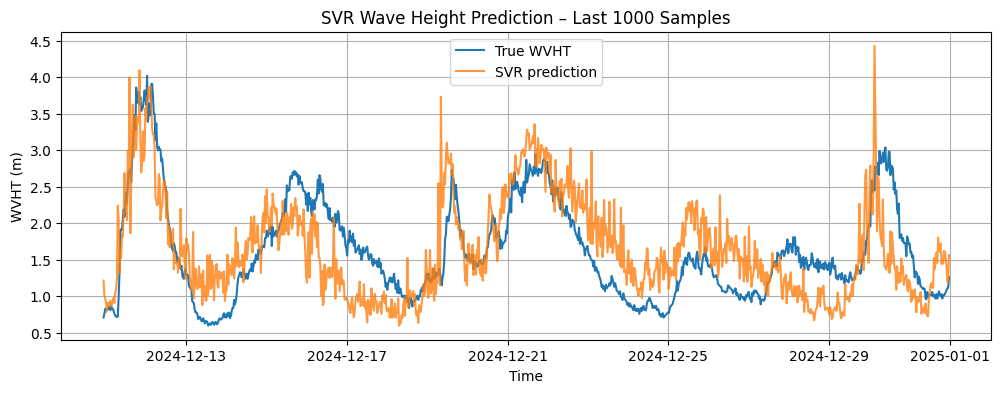

In [11]:
N = 1000
y_test_tail = y_test[-N:]
y_pred_tail = y_pred_svr[-N:]

plt.figure(figsize=(12,4))
plt.plot(y_test_tail.index, y_test_tail.values, label="True WVHT")
plt.plot(y_test_tail.index, y_pred_tail, label="SVR prediction", alpha=0.8)
plt.xlabel("Time")
plt.ylabel("WVHT (m)")
plt.title("SVR Wave Height Prediction – Last 1000 Samples")
plt.legend()
plt.grid(True)
plt.show()
